In [ ]:
%%capture
!pip install super-gradients==3.2.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [ ]:
from super_gradients.training import models

yolo_nas_l = models.get("yolo_nas_l", pretrained_weights="coco")

The console stream is logged into /root/sg_logs/console.log


[2024-07-26 12:05:05] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-07-26 12:05:12] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-07-26 12:05:24] INFO - utils.py - NumExpr defaulting to 2 threads.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
[2024-07-26 12:05:26] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-07-26 12:05:26] WARNING - export.py - Failed to import pytorch_quantization
[2024-07-26 12:05:26] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-07-26 12:05:26] WARNING - env_sanity_check.py - Failed to verify inst

In [ ]:
!pip install torchinfo
from torchinfo import summary

summary(model=yolo_nas_l,
        input_size=(16, 3, 640, 640),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
YoloNAS_L (YoloNAS_L)                                             [16, 3, 640, 640]    [16, 8400, 4]        --                   True
├─NStageBackbone (backbone)                                       [16, 3, 640, 640]    [16, 96, 160, 160]   --                   True
│    └─YoloNASStem (stem)                                         [16, 3, 640, 640]    [16, 48, 320, 320]   --                   True
│    │    └─QARepVGGBlock (conv)                                  [16, 3, 640, 640]    [16, 48, 320, 320]   3,024                True
│    └─YoloNASStage (stage1)                                      [16, 48, 320, 320]   [16, 96, 160, 160]   --                   True
│    │    └─QARepVGGBlock (downsample)                            [16, 48, 320, 320]   [16, 96, 160, 160]   88,128               True
│    │    └─YoloNASCSPLayer (blocks)                     

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [ ]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
# from roboflow import Roboflow
# rf = Roboflow(api_key="<your-roboflow-key-here>")
# project = rf.workspace("atathamuscoinsdataset").project("u.s.-coins-dataset-a.tatham")
# dataset = project.version(5).download("yolov5")
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="G5xqMaFXSm6hBJZGYDOI") # This is my API key!
project = rf.workspace("gongdong").project("beach-cleaner")
version = project.version(2)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.


Extracting Dataset Version Zip to beach-cleaner-2 in yolov8::  55%|█████▌    | 362/654 [00:00<00:00, 3574.20it/s]

Extracting Dataset Version Zip to beach-cleaner-2 in yolov8:: 100%|██████████| 654/654 [00:00<00:00, 3632.65it/s]


In [ ]:
LOCATION = dataset.location
print("location:", LOCATION)
CLASSES = sorted(project.classes.keys())
print("classes:", CLASSES)

location: /content/beach-cleaner-2
classes: ['cat', 'trash']


In [ ]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [ ]:
dataset_params = {
    'data_dir':LOCATION,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': CLASSES
}

You pass the values for `dataset_params` into the `dataset_params` argument as shown below.

You can also pass PyTorch DataLoaders arguments when instantiating your dataset. Here you'll set `batch_size=16` and `num_workers=2`.

Repeat this for the validation and testing datasets, note that for training and testing data we use `coco_detection_yolo_format_val` to instantiate the dataloader.

The dataloaders will print warnings when an annotation does not conform to the expected format. This particular dataset has many such annotations, thus the warnings will be muted.

In [ ]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

Indexing dataset annotations: 100%|██████████| 10/10 [00:00<00:00, 2849.20it/s]


In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

You can plot a batch of training data with their augmentations applied to see what they look like:

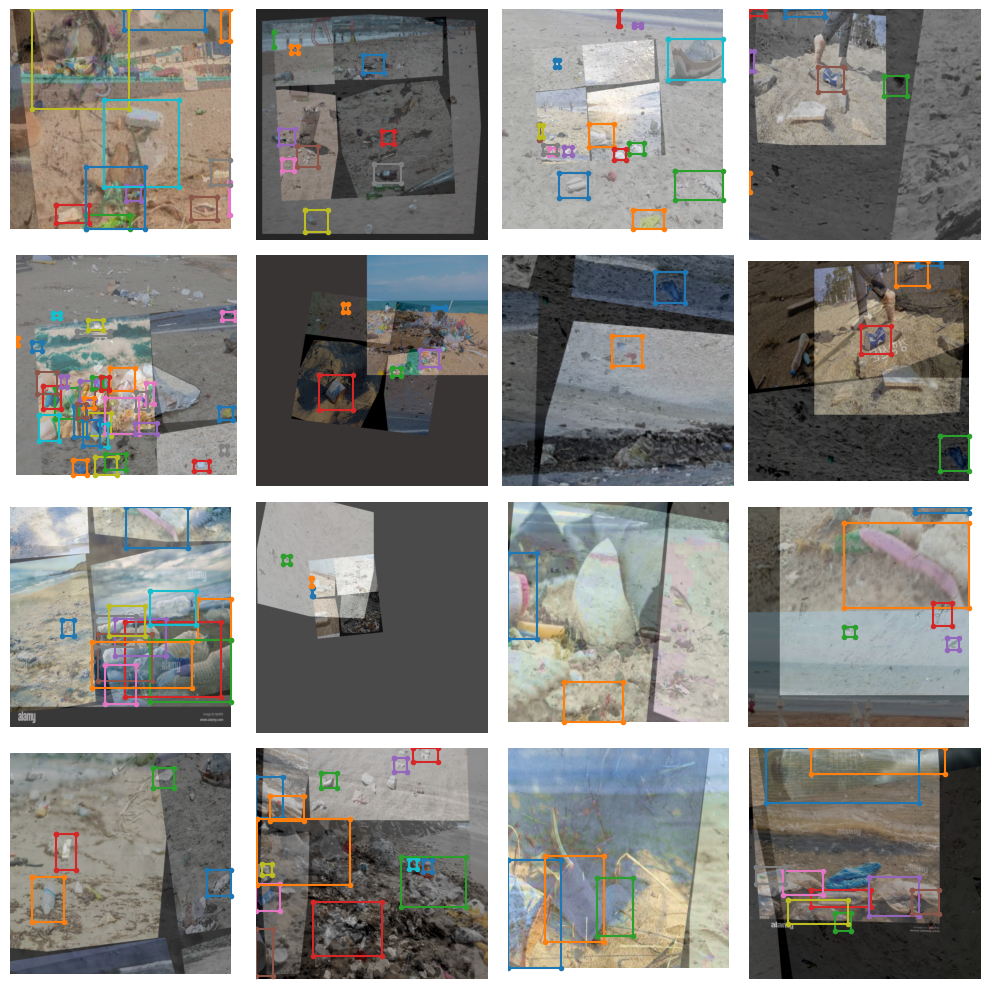

In [ ]:
train_data.dataset.plot()

In [ ]:
from super_gradients.training import models
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2024-07-26 12:26:27] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-07-26 12:26:28] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


# 🎛️ Training parameters

You need to define the training parameters for your training run.

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


### 🚨 There are a few **mandatory** arguments that you must define for training params 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

You can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`.


### 🧑🏾‍🔬 Integrations with experiment monitoring tools

SuperGradients has native integrations with Tensorboard, Weights and Biases, ClearML, and DagsHub.

If your favorite monitoring tool is not supported by SuperGradients, you can simply implement a class inheriting from BaseSGLogger that you will then pass to the training parameters.

If you're interested in monitoring experiments, you can learn more [in the docs](https://github.com/Deci-AI/super-gradients/blob/0fe46cd39572db34eb83d68e343fed97b8886fe9/documentation/source/experiment_monitoring.md).


### 🪄 SuperGradients offers a number of training tricks right out of the box, such as:

- Exponential moving average
- Zero weight decay on bias and batch normalizatiom
- Weight averaging
- Batch accumulation
- Precise BatchNorm

You can read more details about these training tricks [here](https://heartbeat.comet.ml/a-better-way-to-train-your-neural-networks-813b60a5bd6a).

If you're interested in building a using a custom metric with SuperGradients you can learn how [here](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/Metrics.md).

Note you will have to set number of classes in two places below: `PPYoloELoss` and `DetectionMetrics_050`.

You probably noticed that we make use of a post prediction callback, for details on how phase callbacks work in SuperGradients [check out our documentation](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/PhaseCallbacks.md).

### 🔕 Note: I've enabled `silent_mode` so the notebook doesn't get longer than it already is. You should disable it so you can see what SuperGradients outputs during training.

In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": False, #Changed to False because mixed precision is not supported on CPU
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# 🦾 Training the model

You've covered a lot of ground so far:

✅ Instantiated the trainer

✅ Defined your dataset parameters and dataloaders

✅ Instantiated a model

✅ Set up your training parameters

### ⏳ Now, its time to train a model

Training a model using a SuperGradients is done using the `trainer`.

It's as easy as...

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

The console stream is now moved to checkpoints/my_first_yolonas_run/console_Jul26_12_26_43.txt


[2024-07-26 12:26:46] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


AssertionError: mixed precision is not available for CPU

# 🏆 Get the best trained model

Now that training is complete, you need to get the best trained model.

You used checkpoint averaging so the following code will use weights averaged across training runs.

If you want to use the best weights, or weights from the last epoch you'd use one of the following in the code below:

- best weights: `checkpoint_path = checkpoints/my_first_yolonas_run/ckpt_best.pth`

- last weights: `checkpoint_path = checkpoints/my_first_yolonas_run/ckpt_latest.pth`

In [ ]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="checkpoints/my_first_yolonas_run/average_model.pth")

# 🧐 Evaluating the best trained model on the test set

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

# 🔮 Predicting with the best model

The next line will perform detection on the following image. Note, we didn't have a class for the half dollar coin. So it will likely get classified as something else.

<img src='https://www.mynumi.net/media/catalog/product/cache/2/image/9df78eab33525d08d6e5fb8d27136e95/s/e/serietta_usa_2_1/www.mynumi.net-USASE5AD160-31.jpg'>

The results aren't too bad after just a few epochs!





In [ ]:
img_url = 'https://www.mynumi.net/media/catalog/product/cache/2/image/9df78eab33525d08d6e5fb8d27136e95/s/e/serietta_usa_2_1/www.mynumi.net-USASE5AD160-31.jpg'
best_model.predict(img_url).show()

# Post training quantization (PTQ) and quantization aware training (QAT)

SuperGradients offers PTQ and QAT out of the box. That's beyond the scope of this introductory tutorial. It is, in my opinion, a truly awesome feature.

Not many training libaries offer this out of the box.  You can learn more about PTQ and QAT [here](https://github.com/Deci-AI/super-gradients/blob/c339e2619616878172c060e6491c8c2129ed3fd4/documentation/source/ptq_qat.md).

An example specific to YOLONAS can be found [here](https://github.com/Deci-AI/super-gradients/blob/feature/SG-736_deci_yolo_rf100/documentation/source/qat_ptq_yolo_nas.md).

# 💫 I think you're ready to venture out on your own now!

I've created a templated notebook for you [here](https://colab.research.google.com/drive/10N6NmSMCiRnFlKV9kaIS_z3pk0OI1xKC?usp=sharing).

If you run into any issues, you know how to get a hold of me (contact info is at the top of the notebook).

Cheers and I can't wait to see what you come up with!